In [1]:
## general
import numpy as np
import datetime
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import matplotlib as mpl
import math
import pandas as pd

## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro  #check normalicy of seasonal trend distribution
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der, least_squares
from sklearn.preprocessing import StandardScaler
import pickle

##import functions for fitting
from symfit import parameters, variables, Fit
from symfit import pi,sqrt,log,exp,sinh
from symfit import sin, cos


# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/tristan/mesmer/tools/')
from loading import load_data_single_mod
from processing import AR1_predict, compute_llh_cv,gaspari_cohn
from plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
from sklearn.externals import joblib

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` b

In [2]:
def combine_dims(a, start=0, count=2):
    """Reshapes numpy array a by combining count dimensions, 
    starting at the dimension index start"""
    
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start+count:])

In [3]:
def compute_Tan_wgt_reg(reg):
    
    """
    Computes the weighted averaged monthly and annual temperatures for global land, 
    or for a given SREX region.
    Inputs:
    - reg: region: can be 'Global_land', or any of the SREX regions
    - emulator_innovations: output file from the emulations (with lat lon gridded data)
    Outputs:
    - Tan_wgt_reg_y_mon = monthly weighted mean temperature anomaly for the given region
    - Tan_wgt_reg_y = annual weighted mean temperature anomaly for the given region
    """
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
    file_srex_shape = "referenceRegions.shp"

    # SREX names ordered according to SREX mask
    srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 

    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid

    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 

    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land
    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex 
        idx_reg_l_grid = (srex_grid==idx_reg)  

    ## set the timespan of the emulations
    time_emu_mon = pd.date_range(start='1910-01-01', end='2021-12-31', freq='MS')
    time_emu = pd.date_range(start='1910-01-01', end='2021-12-31', freq='A')
    
    Tan_wgt_reg_y_mon = {}
    Tan_wgt_reg_y = {}

    ### calculate monthly average temperature anomalies for the region
    for run in np.arange(len(y_all_mon)):
        Tan_wgt_reg_y_mon[run] = np.zeros(len(time_emu_mon))
        for i in np.arange(len(time_emu_mon)):
            Tan_wgt_reg_y_mon[run][i] = np.average(y_all_mon[run][i][idx_reg_l], weights=wgt_l[idx_reg_l])

    ### calculate monthly average temperature anomalies for the region
    for run in np.arange(len(y_all)):
        Tan_wgt_reg_y[run] = np.zeros(len(time_emu))
        for i in np.arange(len(time_emu)):
            Tan_wgt_reg_y[run][i] = np.average(y_all[run][i][idx_reg_l], weights=wgt_l[idx_reg_l])
        
    return Tan_wgt_reg_y_mon, Tan_wgt_reg_y

In [4]:
dir_data = '/home/tristan/mesmer_data/output/saved-Jul/'
dir_data_big = '/home/tristan/mesmer_data/output/'

start = dt.datetime.now()

emulator_innovations = joblib.load(dir_data_big+'120_emulator_innovations_fmin_log.pkl')
seasonal_trend = joblib.load(dir_data+'seasonal_training_results.pkl')


time_taken = dt.datetime.now() - start
print('time take to load %i emulations: ' %len(emulator_innovations), time_taken)

time take to load 120 emulations:  0:00:10.420383


In [5]:
seasonal_trend.shape

(1344, 3043)

In [6]:
# create y_all_mon and y_all (gridpoint (not averaged accross any region) data) for the emulations

y_all_mon = {}
y_all = {}
for run in tqdm(np.arange(len(emulator_innovations))):
    y_all_mon[run] = combine_dims(emulator_innovations[run], 0)
    y_all_mon[run] = np.add(y_all_mon[run], seasonal_trend)
    y_all[run] = np.mean(y_all_mon[run].reshape(-1,12,3043),axis=1)
    
y_all_mon[1].max()

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/120 [00:00<?, ?it/s]

33.49041970068481

-40.12855279822247

In [7]:
## create averaged monthly values for different regions

y_all_mon_gl, y_all_gl = compute_Tan_wgt_reg('Global_land')

In [8]:
for run in np.arange(len(y_all_gl)):
    print(y_all_mon_gl[run].min(), y_all_mon_gl[run].max())

-8.498472497916797 8.003468291248469
-8.463038344839452 7.988703574033979
-8.476425986720061 7.935446775754605
-8.517917912041963 8.009364524438086
-8.536358177931495 7.916781482665527
-8.508206118623944 7.981355455313117
-8.584731085764444 7.938773767515163
-8.51332228652092 7.829075859218813
-8.670441742309713 8.109624006315451
-8.759214056129661 7.986040438170145
-8.656056532754045 8.011257018259743
-8.775068787851659 8.030667816517248
-8.724392835455024 8.013138393517359
-8.577804661617773 8.128618407470357
-8.577377620102837 8.064216723259745
-8.515237285254637 8.08395931108077
-8.581204398892158 7.954746152052887
-8.799415184338294 7.98005982495592
-8.9115269938992 8.090363769332521
-8.83263576660392 7.963093341319283
-8.473248378185565 8.015164581128438
-8.497413089870392 8.056988843691448
-8.640249320521628 7.849050978466776
-8.629970320178316 8.008875390531713
-8.810446329199605 8.128447864930736
-8.57321476000144 8.01915598795722
-8.481144782698117 8.054059147012921
-8.621719

## Plot the data

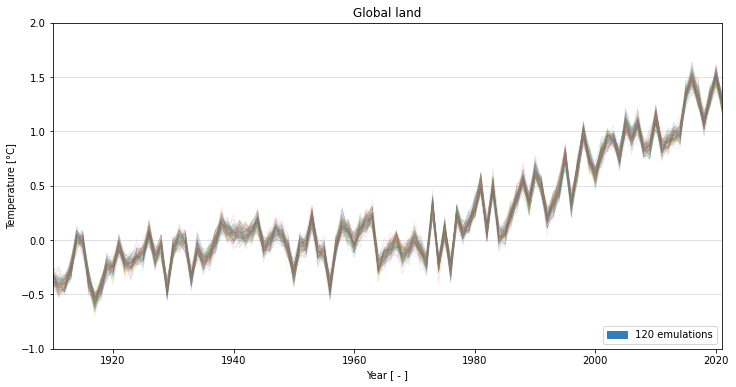

In [18]:
## for monthly data
# time_all = pd.date_range('1910-01-01', '2021-12-31', freq='MS')
# time_all = time_all + pd.Timedelta(15, unit='d')

#for annual data
time_ann = pd.date_range('1910-01-01', '2021-12-31', freq='AS')
time_mon = pd.date_range('1910-01-01', '2021-12-31', freq='MS')

fig=plt.figure(figsize=(12,6))

### set boundaries for y-axis
y_min = -1.0
y_max = 2.0
plt.ylim([y_min,y_max])

##create legend
#obs_lg = mpatches.Patch(color="k", label="Observations (BEST & GISS)")
runs_lg = mpatches.Patch(color="#377eb8", label="120 emulations")

for run in np.arange(len(y_all_gl)):
        plt.plot(time_ann, y_all_gl[run], lw=0.5, alpha=0.2)
        #plt.plot(time_mon, y_all_mon_gl[run], color='grey',lw=0.5,alpha=0.6)

#for dataset in datasets:
    #plt.plot(time_obs_ann, obs_ann[dataset], color="k", alpha=0.35)

plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')
leg = plt.legend(handles=[runs_lg], loc="lower right", prop={'size': 10})

# ax_sub = fig.add_axes([0.15, 0.65, 0.2, 0.2],projection=ccrs.Robinson(central_longitude=0))
# mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
# ax_sub.coastlines(lw=0.5)
# ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()